In [1]:
!pip install audiolazy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal import hann, hamming
from librosa import lpc
#from audiolazy import lazy_lpc as lpc
from scipy.signal import hamming, freqz
#from audiolazy import lazy_lpc


In [3]:
# provided functions
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analysis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    #cor = np.correlate(x, x, mode='full')
    cor = lb.autocorrelate(x, max_size=len(x)-1)
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from mean are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### 1. Linear prediction analysis. (1 point) 

C:\Users\praba\AppData\Local\Temp\ipykernel_26300\1901172987.py:13: RuntimeWarning: invalid value encountered in sqrt
  g = np.sqrt(np.sum(a*rr))


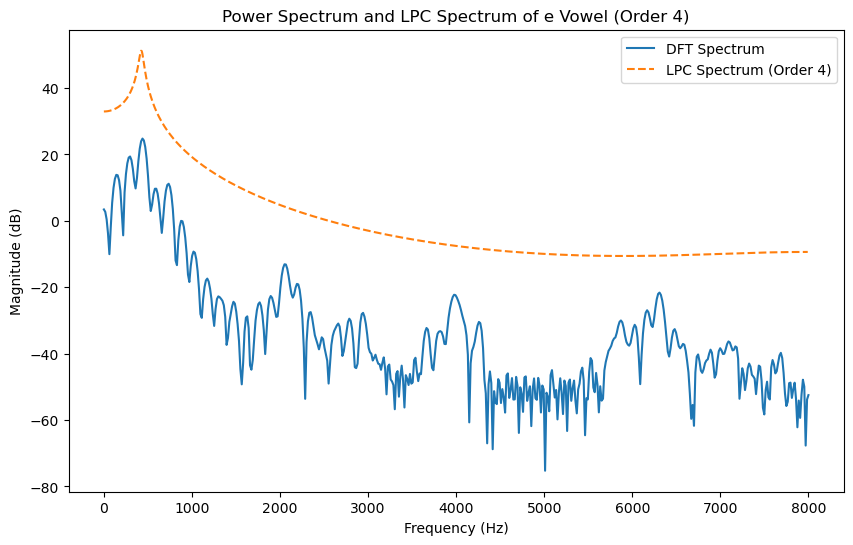

<Figure size 640x480 with 0 Axes>

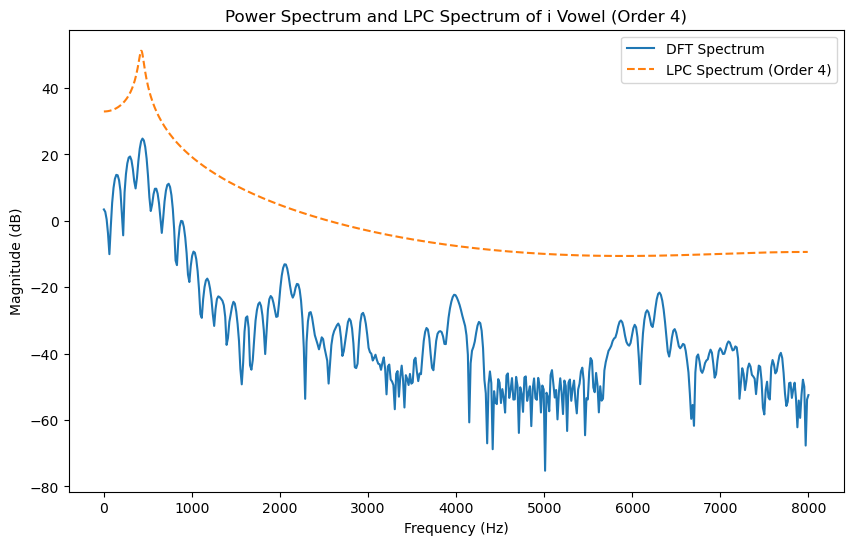

<Figure size 640x480 with 0 Axes>

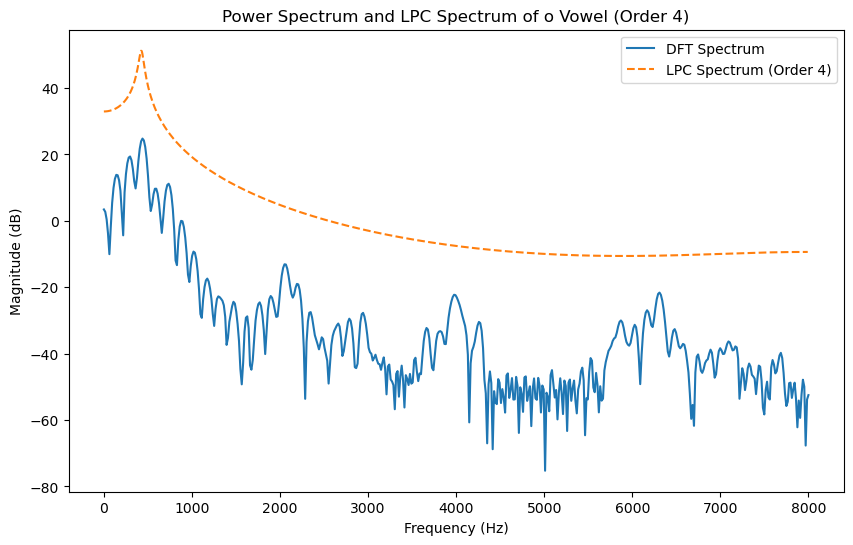

<Figure size 640x480 with 0 Axes>

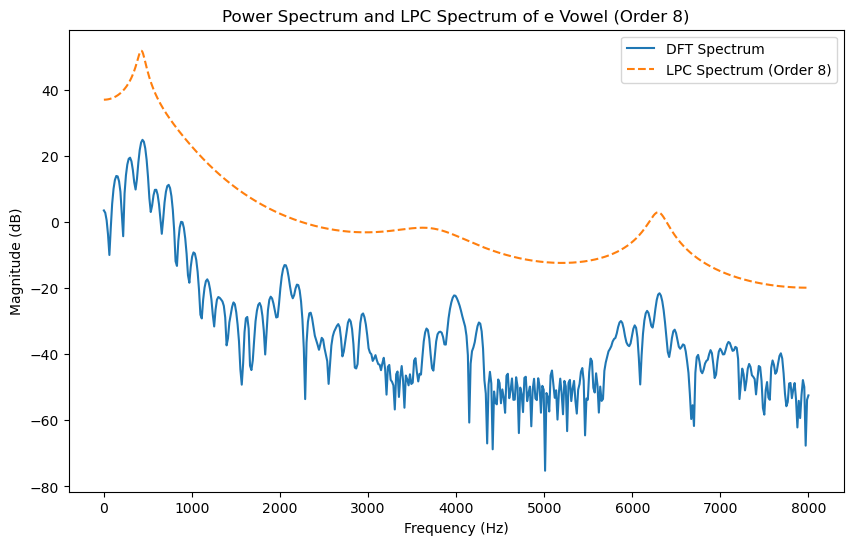

<Figure size 640x480 with 0 Axes>

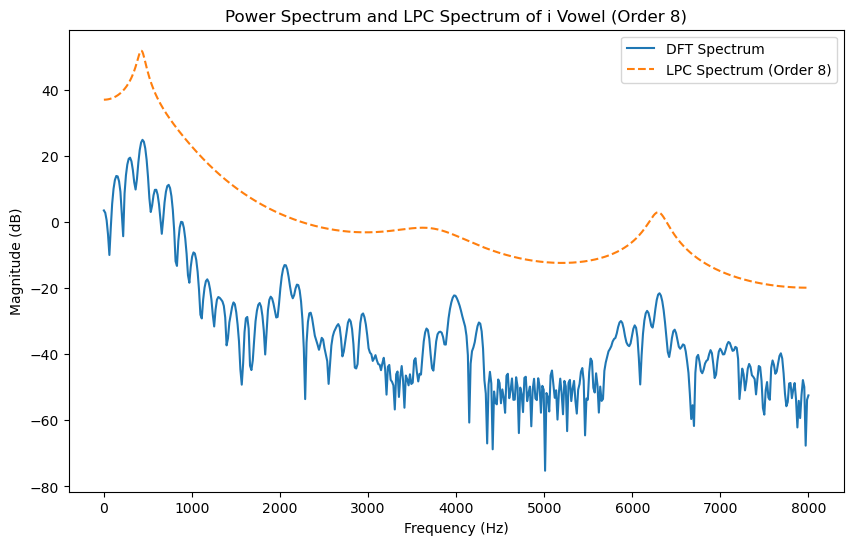

<Figure size 640x480 with 0 Axes>

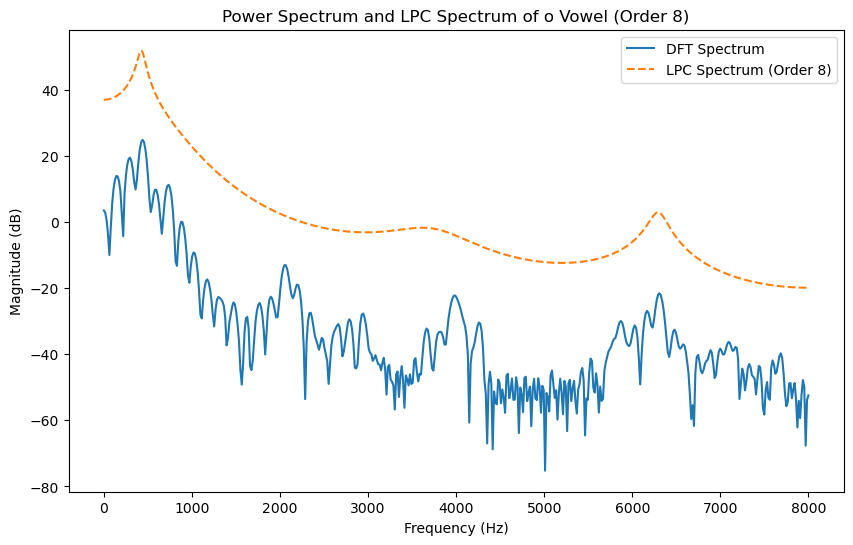

<Figure size 640x480 with 0 Axes>

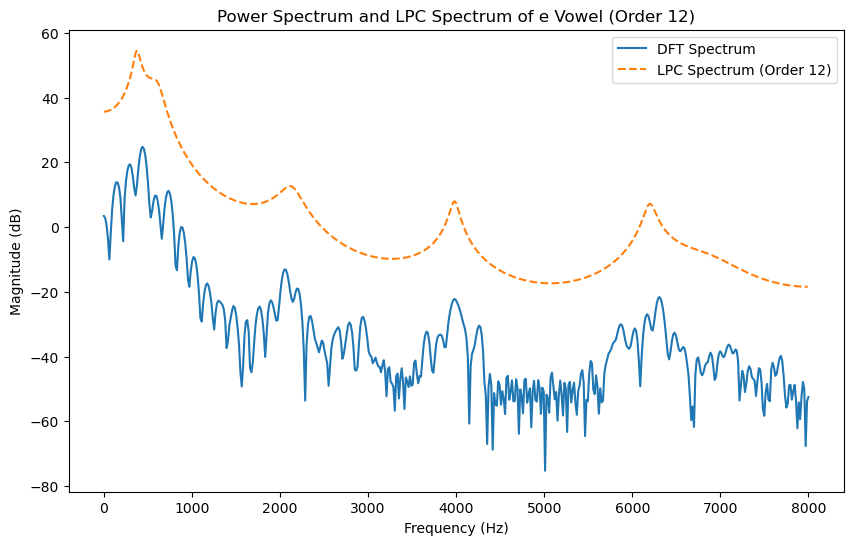

<Figure size 640x480 with 0 Axes>

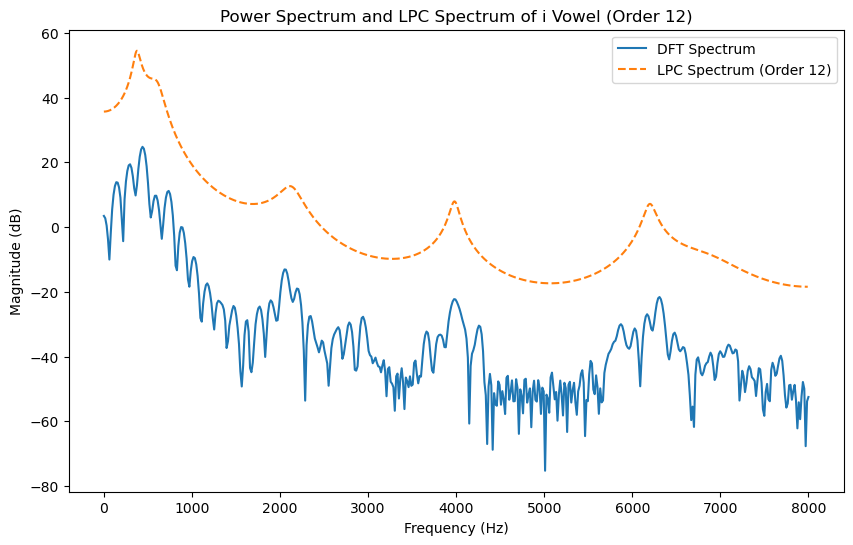

<Figure size 640x480 with 0 Axes>

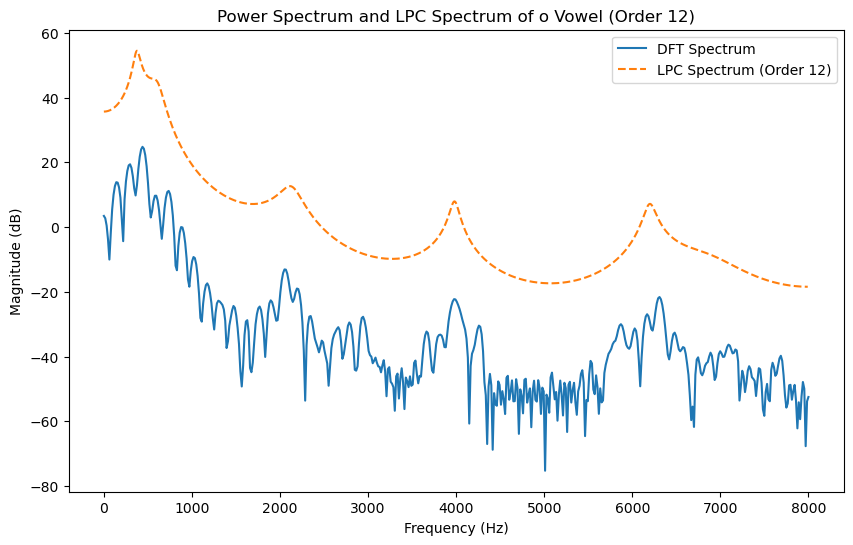

<Figure size 640x480 with 0 Axes>

In [5]:
# Read audio
audio_files = ['e.wav', 'i.wav', 'o.wav']

# filter order
p = 4

# number of DFT points
nfft = 1024

for vowel_audio in audio_files:
    # Read audio
    audioIn, fs = lb.load(vowel_audio, sr=None)

   
 # choose a representative frame of the vowel
    
    
for p_value in [4, 8, 12]:
    for vowel_audio in audio_files:
        # Read audio
        wLen = int(0.02 * fs)  # 20 ms window
        win = hamming(wLen)  # hamming window
        Len = int(0.02 * fs)  # 20 ms window
        inInd = 0
        cnt = 0
        numframes = np.ceil((len(audioIn) - wLen) / (wLen / 2))
  
        formants = []  # A placeholder for storing formants

        # choose a representative frame of the vowel
        plot_frame = int(numframes / 2)  # middle of the vowel

        # The analysis loop
        while inInd < len(audioIn) - wLen:
            # audio frame
            frame = audioIn[inInd:inInd + wLen] * win

            # a) compute LPC and gain using audiolazy library
            lpc_coeffs = lb.core.lpc(frame, order=p_value)
            gain = est_predictor_gain(frame, lpc_coeffs, p_value)

            # b) Compute the filter transfer function using scipy.signal.freqz
            w, h = freqz(1, lpc_coeffs, worN=nfft, fs=fs)

            # Compute DFT spectrum
            frame_spectrum = 20 * np.log10(np.abs(np.fft.fft(frame, n=nfft)[:nfft // 2]))

            inInd = inInd + int(wLen / 2)  # frame advance
            cnt = cnt + 1

            # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
            if cnt == plot_frame:
                # plot DFT spectrum (remember both in dB scale)
                plt.figure(figsize=(10, 6))
                plt.plot(np.linspace(0, fs / 2, nfft // 2), frame_spectrum, label='DFT Spectrum')

                # plot LPC spectrum
                lpc_spectrum = 20 * np.log10(np.abs(h))
                plt.plot(w, lpc_spectrum, label=f'LPC Spectrum (Order {p_value})', linestyle='dashed')

                plt.title(f'Power Spectrum and LPC Spectrum of {vowel_audio[:-4]} Vowel (Order {p_value})')
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Magnitude (dB)')
                plt.legend()
                plt.show()
                plt.figure()

#### d) Comment of the connection between lpc model order and peaks in the DFT spectrum.

In [ ]:
The frequency content of a signal is represented by the DFT spectrum, whereas the number of coefficients applied in the 
prediction model is determined by the LPC model order. The LPC model harmonics commonly align with the peaks detected 
in the DFT spectrum, thereby capturing the fundamental frequencies related to  sounds. However, an overly high model order
may result in overfitting.

#### Is the best order selection dependent on the vowel or not?

In [ ]:
yes, It is important that the LPC model order accurately reflects the spectral characteristics of vowel sounds by
capturing the formant frequencies of unique vowels.

### 2. Formant analysis. (1 point)

#### Add more steps in the previous analysis loop

In [8]:
audio_files = ['e.wav', 'i.wav', 'o.wav']

# filter order
p = 4

# number of DFT points
nfft = 1024

for vowel_audio in audio_files:
    # Read audio
    audioIn, fs = lb.load(vowel_audio, sr=None)

    # choose a representative frame of the vowel
    plot_frame = int(len(audioIn) / 2)  # middle of the vowel

    for p_value in [4, 8, 12]:
        wLen = int(0.02 * fs)  # 20 ms window
        win = hamming(wLen)  # hamming window
        inInd = 0
        cnt = 0
        numframes = np.ceil((len(audioIn) - wLen) / (wLen / 2))

        formants = []  # A placeholder for storing formants

        # The analysis loop
        while inInd < len(audioIn) - wLen:
            # audio frame
            frame = audioIn[inInd:inInd + wLen] * win

            # a) compute LPC and gain using audiolazy library
            lpc_coeffs = lb.core.lpc(frame, order=p_value)
            gain = est_predictor_gain(frame, lpc_coeffs, p_value)

            # b) Compute the filter transfer function using scipy.signal.freqz
            w, h = freqz(1, lpc_coeffs, worN=nfft, fs=fs)

            # Compute DFT spectrum
            frame_spectrum = 20 * np.log10(np.abs(np.fft.fft(frame, n=nfft)[:nfft // 2]))

            # a) Compute roots (np.roots)
            roots = np.roots(lpc_coeffs)

            # LPC coefficients are real-valued, the roots occur in complex conjugate pairs.
            # Retain only the roots with +ve sign for the imaginary part
            roots = roots[np.imag(roots) > 0]

            # b.1) compute formants from roots (np.angle)
            angz = np.angle(roots)

            # convert to Hertz from angular frequencies
            angz = angz * (fs / (2 * np.pi))

            # sort the formants in increasing order
            angz = np.sort(angz)

            # remove zero frequencies
            angz = angz[angz != 0]

            # b.2) Save first three formants
            formants.append(angz[:3])

            inInd = inInd + int(wLen / 2)  # frame advance
            cnt = cnt + 1

            

      # Pad shorter arrays with zeros
        formants = [np.pad(f, (0, 3 - len(f))) for f in formants]
        formants = np.array(formants)
        
        # b.3) For each separate vowel calculate average formant frequencies
        print(f'------ The computed formants for {vowel_audio[:-4]} for Vowel (Order {p_value}) are:', np.mean(formants))

        # Refine formant estimations (optional)
        refined_formants = reject_outliers(formants, m=2)
        refined_avg_formants = np.mean(refined_formants, axis=0)
        print(f'------ The refined formants for {vowel_audio[:-4]} for Vowel (Order {p_value}) are:', refined_avg_formants)

------ The computed formants for e for Vowel (Order 4) are: 1027.5264551228095
------ The refined formants for e for Vowel (Order 4) are: 977.5635711715166
------ The computed formants for e for Vowel (Order 8) are: 2061.005008973577
------ The refined formants for e for Vowel (Order 8) are: 1936.8060420585834
------ The computed formants for e for Vowel (Order 12) are: 1976.8677717596404
------ The refined formants for e for Vowel (Order 12) are: 1950.5385142439764
------ The computed formants for i for Vowel (Order 4) are: 1226.7572306431905
------ The refined formants for i for Vowel (Order 4) are: 1157.9881853027687
------ The computed formants for i for Vowel (Order 8) are: 2214.961995193965
------ The refined formants for i for Vowel (Order 8) are: 2085.2276648049233
------ The computed formants for i for Vowel (Order 12) are: 2075.3809873829528
------ The refined formants for i for Vowel (Order 12) are: 2075.3809873829528
------ The computed formants for o for Vowel (Order 4) ar

C:\Users\praba\AppData\Local\Temp\ipykernel_26300\1901172987.py:13: RuntimeWarning: invalid value encountered in sqrt
  g = np.sqrt(np.sum(a*rr))


#### b.4) Compare the obtained values with the indicative values. 

In [ ]:
according to the provided link and values which compusted, specially order 12 are more closer to the table. 
However, computed values are bit less than provided formants values which may cause due to noise of the signal values are 

### Bonus problem: What happens if you apply LPC to the oboe sound? What are the corresponding "formants"?